## Research Question

To find the sentiments on movie reviews

## Expected Data Source

https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/data

## Techniques expected to use in the analysis

Natural Language Processing, N-gram

## Expected Results

Movie reviews are labelled with sentiments like negative, somewhat negative, neutral, somewhat positive, positive.
Based on the sentiments, recommend/not recommend the movie to people.

## Importance of the topic

It can help people to know whether the movie is good or not before watching. It can save a lot of their time and money when choosing movie to watch. 

It can let the movie producer to know how to improve the movie quality by understanding audiences' feelings.

## Import Libraries

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score, recall_score, f1_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dennis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dennis\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Dennis\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Dennis\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dennis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dennis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is alrea

## Data Preprocess

In [102]:
# only the training dataset contains sentiment result, so I just use training dataset here
df=pd.read_csv('./data/train.tsv.zip',sep='\t')

# the test dataset does not contain expected sentiment results. It is for competition. So I ignored it
# test_df=pd.read_csv('./data/test.tsv.zip',sep='\t')

In [4]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [103]:
df_with_description = df.copy()

df_with_description['Sentiment Description'] = pd.DataFrame(df_with_description['Sentiment'].replace(0,'Negative').replace(1,'Somewhat Negative').replace(2,'Neutral').replace(3,'Somewhat Positive').replace(4,'Positive'))

In [6]:
df_with_description.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment Description
0,1,1,A series of escapades demonstrating the adage ...,1,Somewhat Negative
1,2,1,A series of escapades demonstrating the adage ...,2,Neutral
2,3,1,A series,2,Neutral
3,4,1,A,2,Neutral
4,5,1,series,2,Neutral


## Explore Data

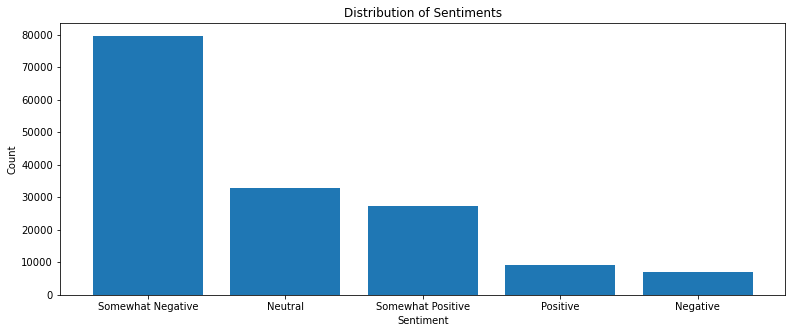

In [104]:
# show bar chart for distribution of sentiments in the dataset
plt.figure(figsize=(13,5))
plt.bar(height=df_with_description['Sentiment Description'].value_counts(), x=df_with_description['Sentiment Description'].unique())
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

<AxesSubplot:title={'center':'Distribution of Sentiments'}, ylabel='Sentiment Description'>

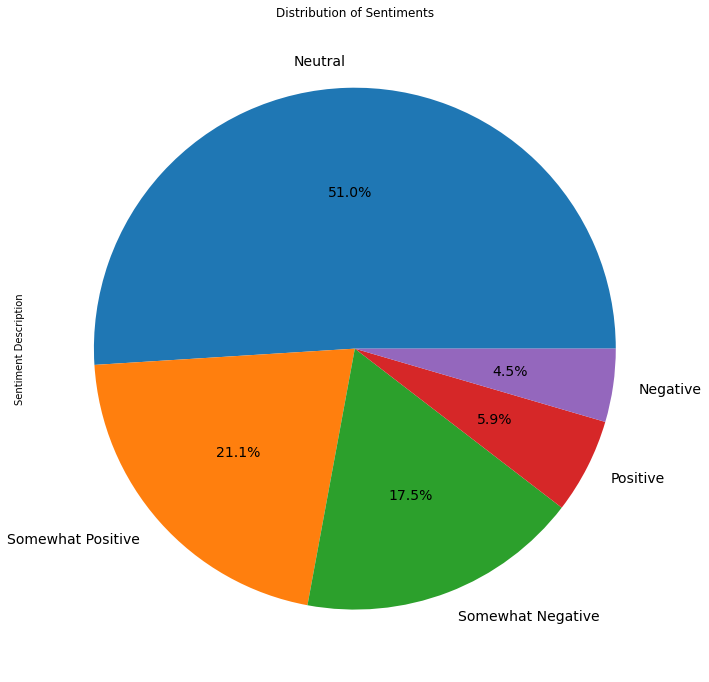

In [112]:
# show pie chart for distribution of sentiments in the dataset
pie_chart=pd.DataFrame(df_with_description['Sentiment Description'].value_counts())
pie_chart.reset_index(inplace=True)
pie_chart.plot(kind='pie', title='Distribution of Sentiments',y = 'Sentiment Description', 
          autopct='%1.1f%%', shadow=False, labels=pie_chart['index'], legend = False, fontsize=14, figsize=(12,12))

From the pie chart above, the most frequently seen data is coming from Neutral reviews.

Text(0.5, 0.98, 'Phrase length distribution under different sentiments')

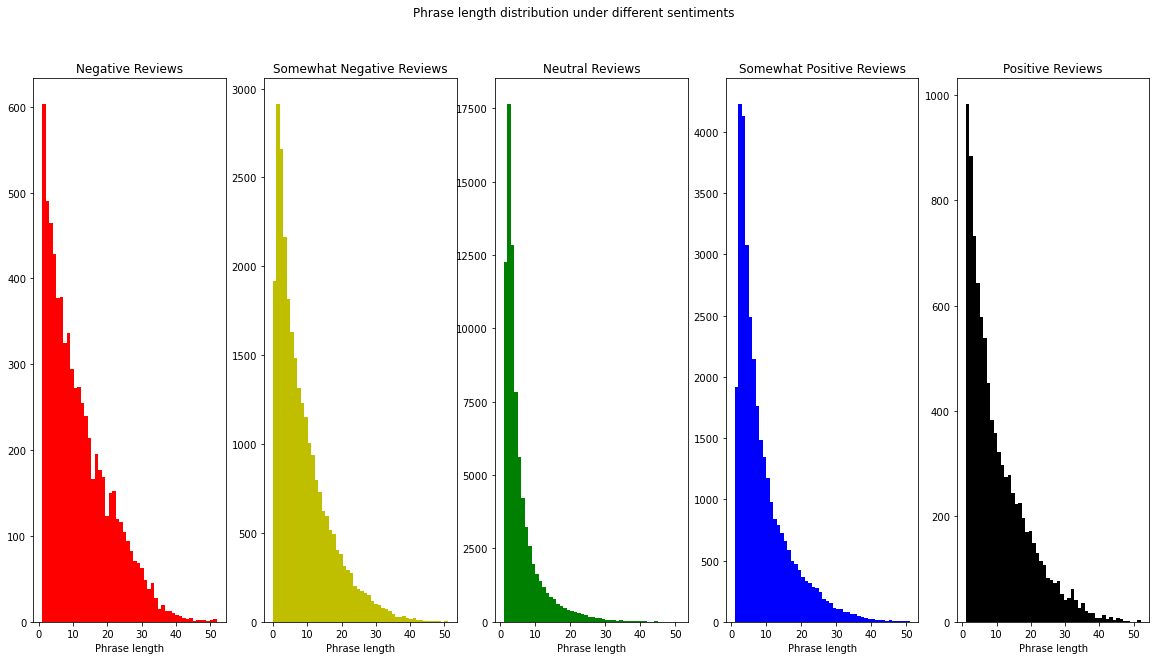

In [121]:
# show phrase length distribution under different sentiments
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(20,10))

ax1.hist(df_with_description[df_with_description['Sentiment'] == 0]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='r')
ax1.set_title('Negative Reviews')
ax1.set_xlabel('Phrase length')

ax2.hist(df_with_description[df_with_description['Sentiment'] == 1]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='y')
ax2.set_title('Somewhat Negative Reviews')
ax2.set_xlabel('Phrase length')

ax3.hist(df_with_description[df_with_description['Sentiment'] == 2]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='g')
ax3.set_title('Neutral Reviews')
ax3.set_xlabel('Phrase length')

ax4.hist(df_with_description[df_with_description['Sentiment'] == 3]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='b')
ax4.set_title('Somewhat Positive Reviews')
ax4.set_xlabel('Phrase length')

ax5.hist(df_with_description[df_with_description['Sentiment'] == 4]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='k')
ax5.set_title('Positive Reviews')
ax5.set_xlabel('Phrase length')

f.suptitle('Phrase length distribution under different sentiments')

In the histograms above, the distribution behaves like a negative exponential function. As x increases, y decreases.

In [150]:
print('Length Distribution of Phrases:')
df_len10=pd.DataFrame(df_with_description['Phrase'].str.split().map(lambda x: len(x))>=10)
print('Number of phrases which contain more than 10 words: ', df_len10.loc[df_len10['Phrase']==True].shape[0])
df_len20=pd.DataFrame(df_with_description['Phrase'].str.split().map(lambda x: len(x))>=20)
print('Number of phrases which contain more than 20 words: ', df_len20.loc[df_len20['Phrase']==True].shape[0])
df_len30=pd.DataFrame(df_with_description['Phrase'].str.split().map(lambda x: len(x))>=30)
print('Number of phrases which contain more than 30 words: ', df_len30.loc[df_len30['Phrase']==True].shape[0])
df_len40=pd.DataFrame(df_with_description['Phrase'].str.split().map(lambda x: len(x))>=40)
print('Number of phrases which contain more than 40 words: ', df_len40.loc[df_len40['Phrase']==True].shape[0])
df_len50=pd.DataFrame(df_with_description['Phrase'].str.split().map(lambda x: len(x))>=50)
print('Number of phrases which contain more than 50 words: ', df_len50.loc[df_len50['Phrase']==True].shape[0])

Length Distribution of Phrases:
Number of phrases which contain more than 10 words:  39540
Number of phrases which contain more than 20 words:  11494
Number of phrases which contain more than 30 words:  2568
Number of phrases which contain more than 40 words:  352
Number of phrases which contain more than 50 words:  18


## Further Data Preprocess

In [23]:
# remove non-alphabetical characters
def remove_non_alphabets(text):
    return re.sub('[^a-zA-Z]', ' ', text)

df_with_description['Phrase preprocessed'] = df_with_description['Phrase'].apply(remove_non_alphabets)

# all words to lower case
def lower_case(text):
    return text.lower()

df_with_description['Phrase preprocessed'] = df_with_description['Phrase preprocessed'].apply(lower_case)

In [109]:
df_with_description.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment Description
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1,Somewhat Negative
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2,Neutral
2,3,1,A series,2,Neutral
3,4,1,A,2,Neutral
4,5,1,series,2,Neutral


In [28]:
# apply stemming and lemmatizing
def stemmer(text):
    stem = PorterStemmer()
    return ' '.join([stem.stem(word) for word in word_tokenize(text)])

def lemmatizer(text):
    lemma = WordNetLemmatizer()
    return ' '.join([lemma.lemmatize(word) for word in word_tokenize(text)])

stemmed_content_with_stopwords = df_with_description['Phrase'].apply(stemmer)

lemmatized_content_with_stopwords = df_with_description['Phrase'].apply(lemmatizer)

In [30]:
# split into training and test datasets
X_train_stemmed, X_test_stemmed, y_train_stemmed, y_test_stemmed = train_test_split(stemmed_content_with_stopwords, df_with_description['Sentiment Description'], random_state = 42)
X_train_lemmatized, X_test_lemmatized, y_train_lemmatized, y_test_lemmatized = train_test_split(lemmatized_content_with_stopwords, df_with_description['Sentiment Description'], random_state = 42)

## Model Building

In [41]:
def get_gridSearchCVResult_of_nlp_pipeline(methodsToUse, params_for_grid, X_train, y_train, X_test, y_test):
    pipeline = Pipeline(methodsToUse)
    grid = GridSearchCV(pipeline, param_grid = params_for_grid, n_jobs=-1)
    grid.fit(X_train, y_train)
    grid_acc_score = grid.score(X_test, y_test)
    return { 'gridSearchCV_result': grid, 'grid_acc_score': grid_acc_score }

In [42]:
# initialize datasets and parameters
results = []

datasets = {
    'Stemmed':[X_train_stemmed, X_test_stemmed, y_train_stemmed, y_test_stemmed],
    'Lemmatized':[X_train_lemmatized, X_test_lemmatized, y_train_lemmatized, y_test_lemmatized]
}

params_cvent = {'cvect__max_features': [100, 500, 1000, 2000],
         'cvect__stop_words': ['english', None]}

params_tfidf = {'tfidf__max_features': [500, 1000, 2000],
         'tfidf__stop_words': ['english', None],
         'tfidf__ngram_range': ((1, 1), (2, 2), (3,3),(1,2))}
# can set 'tfidf__use_idf': (True, False)" if have time or much powerful computer

In [33]:
# Find the best params from CountVectorizer + LogisticRegression

for dataset in datasets:
    cvect_lgr_pipe = get_gridSearchCVResult_of_nlp_pipeline(
                    [('cvect', CountVectorizer()),('lgr', LogisticRegression(max_iter=10000))],
                    params_cvent,
                    datasets[dataset][0], datasets[dataset][2],
                    datasets[dataset][1], datasets[dataset][3])
    results.append({'Preprocessing':dataset,'Feature Extraction Method':'CountVectorizer','ML Method':'Logistic Regression', 'Result': cvect_lgr_pipe})

In [34]:
# Find the best params from CountVectorizer + DecisionTreeClassifier
for dataset in datasets:
    cvect_dt_pipe = get_gridSearchCVResult_of_nlp_pipeline(
                    [('cvect', CountVectorizer()), ('dt', DecisionTreeClassifier())],
                    params_cvent,
                    datasets[dataset][0], datasets[dataset][2],
                    datasets[dataset][1], datasets[dataset][3])
    results.append({'Preprocessing':dataset,'Feature Extraction Method':'CountVectorizer','ML Method':'Decision Tree', 'Result': cvect_dt_pipe})

In [35]:
# Find the best params from CountVectorizer + MultinomialNB
for dataset in datasets:
    cvect_nb_pipe = get_gridSearchCVResult_of_nlp_pipeline(
                    [('cvect', CountVectorizer()), ('nb', MultinomialNB())],
                    params_cvent,
                    datasets[dataset][0], datasets[dataset][2],
                    datasets[dataset][1], datasets[dataset][3])
    results.append({'Preprocessing':dataset,'Feature Extraction Method':'CountVectorizer','ML Method':'Bayes', 'Result': cvect_nb_pipe})

In [40]:
# Find the best params from TfidfVectorizer + LogisticRegression
for dataset in datasets:
    tfidf_lgr_pipe = get_gridSearchCVResult_of_nlp_pipeline(
                    [('tfidf', TfidfVectorizer()),  ('lgr', LogisticRegression(max_iter=10000))],
                    params_tfidf,
                    datasets[dataset][0], datasets[dataset][2],
                    datasets[dataset][1], datasets[dataset][3])
    results.append({'Preprocessing':dataset,'Feature Extraction Method':'TfidfVectorizer','ML Method':'Logistic Regression', 'Result': tfidf_lgr_pipe})

In [43]:
# Find the best params from TfidfVectorizer + DecisionTreeClassifier
for dataset in datasets:
    tfidf_dt_pipe = get_gridSearchCVResult_of_nlp_pipeline(
                    [('tfidf', TfidfVectorizer()),  ('dt', DecisionTreeClassifier())],
                    params_tfidf,
                    datasets[dataset][0], datasets[dataset][2],
                    datasets[dataset][1], datasets[dataset][3])
    results.append({'Preprocessing':dataset,'Feature Extraction Method':'TfidfVectorizer','ML Method':'Decision Tree', 'Result': tfidf_dt_pipe})

In [44]:
# Find the best params from TfidfVectorizer + MultinomialNB
for dataset in datasets:
    tfidf_nb_pipe = get_gridSearchCVResult_of_nlp_pipeline(
                    [('tfidf', TfidfVectorizer()),  ('nb', MultinomialNB())],
                    params_tfidf,
                    datasets[dataset][0], datasets[dataset][2],
                    datasets[dataset][1], datasets[dataset][3])
    results.append({'Preprocessing':dataset,'Feature Extraction Method':'TfidfVectorizer','ML Method':'Bayes', 'Result': tfidf_nb_pipe})

In [100]:
# Show the results
pd.set_option('display.max_colwidth', None)
pd.DataFrame({
    'Stemmed/Lemmatized':[result['Preprocessing'] for result in results],
    'Feature Extraction Method': [result['Feature Extraction Method'] for result in results],
    'ML Method': [result['ML Method'] for result in results], 
    'best_params': [result['Result']['gridSearchCV_result'].best_params_ for result in results],
    'best_score': [result['Result']['gridSearchCV_result'].best_score_ for result in results],
    'mean fit time in sec': [result['Result']['gridSearchCV_result'].cv_results_['mean_fit_time'].mean() for result in results],
})

,Stemmed/Lemmatized,Feature Extraction Method,ML Method,best_params,best_score,mean fit time in sec
0,Stemmed,CountVectorizer,Logistic Regression,"{'cvect__max_features': 2000, 'cvect__stop_words': None}",0.611474,47.677805
1,Lemmatized,CountVectorizer,Logistic Regression,"{'cvect__max_features': 2000, 'cvect__stop_words': None}",0.607219,54.734529
2,Stemmed,CountVectorizer,Decision Tree,"{'cvect__max_features': 2000, 'cvect__stop_words': 'english'}",0.611175,42.084241
3,Lemmatized,CountVectorizer,Decision Tree,"{'cvect__max_features': 2000, 'cvect__stop_words': 'english'}",0.608689,40.468003
4,Stemmed,CountVectorizer,Bayes,"{'cvect__max_features': 2000, 'cvect__stop_words': None}",0.596642,5.117055
5,Lemmatized,CountVectorizer,Bayes,"{'cvect__max_features': 2000, 'cvect__stop_words': None}",0.594224,6.008335
6,Stemmed,TfidfVectorizer,Logistic Regression,"{'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}",0.609791,45.122414
7,Lemmatized,TfidfVectorizer,Logistic Regression,"{'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}",0.606066,39.515335
8,Stemmed,TfidfVectorizer,Decision Tree,"{'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': 'english'}",0.602640,30.269534
9,Lemmatized,TfidfVectorizer,Decision Tree,"{'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': 'english'}",0.602298,30.071770


## Evaluation

From the GridSearchCV results above, The first best score comes from Stemmed Content + CountVectorizer with Logistic Regression, while the second best score comes from Stemmed Content + CountVectorizer with Decision Tree.  However, there is around 5.5 seconds mean fit time more to spend on the first best model to beat the second one with an insignificant 0.003 score. Therefore, I chose the second best model to build and evaluate.

In [62]:
# build the "best" model
pipeline = Pipeline(steps=[('cvect', CountVectorizer(max_features=2000,stop_words='english')),
                           ('dt', DecisionTreeClassifier())])

pipeline.fit(X_train_stemmed, y_train_stemmed)

Pipeline(steps=[('cvect',
                 CountVectorizer(max_features=2000, stop_words='english')),
                ('dt', DecisionTreeClassifier())])

In [155]:
# obtain the confusion matrix
y_train_pred = cross_val_predict(pipeline, X_train_stemmed, y_train_stemmed, cv=10, n_jobs=-1)
conf_mat = confusion_matrix(y_train_stemmed, y_train_pred)

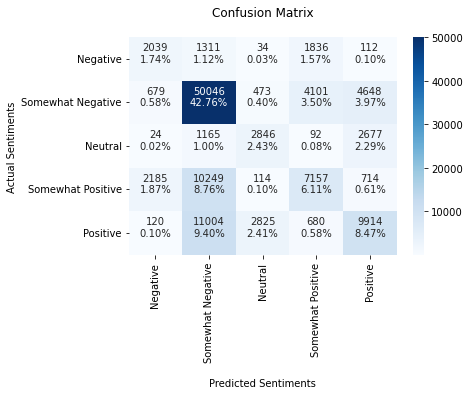

In [158]:
# draw confusion matrix
group_counts = ["{0:0.0f}".format(value) for value in
                conf_mat.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     conf_mat.flatten()/np.sum(conf_mat)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(5,5)

ax = sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Sentiments')
ax.set_ylabel('Actual Sentiments');

ax.xaxis.set_ticklabels(['Negative','Somewhat Negative', 'Neutral','Somewhat Positive','Positive'])
plt.xticks(rotation=90) 
ax.yaxis.set_ticklabels(['Negative','Somewhat Negative', 'Neutral','Somewhat Positive','Positive'])
plt.yticks(rotation=0) 

plt.show()

In [162]:
cross_val_acc = cross_val_score(pipeline, X_train_stemmed, y_train_stemmed, cv=3, scoring="accuracy", n_jobs=-1)
print('Mean Cross Validation Score: ', cross_val_acc.mean(), '(std: ',cross_val_acc.std(),')')
# Find precision, recall and F1 score
print('Precision: ', precision_score(y_train_stemmed, y_train_pred, average = 'weighted'))
print('Recall: ', recall_score(y_train_stemmed, y_train_pred, average = 'weighted'))
print ('F1 score: ', f1_score(y_train_stemmed, y_train_pred, average = 'weighted'))

Mean Cross Validation Score:  0.6042120551924474 (std:  0.0018923525662161316 )
Precision:  0.5972560139896786
Recall:  0.6151651074373105
F1 score:  0.5969439784923416


## Conclusion

Movie reviews are labelled with sentiments like negative, somewhat negative, neutral, somewhat positive, positive. Natural Language processing techniques are used to understand the sentiment in the moview reviews. Based on the model I built, movies can be recommended/not recommended to people. It can also helps the filming industry to know what kind of movies the large audience likes to watch.

I have first applied stemming and lemmatizing to preprocess the data. Then I used GridSearchCV to find the best machine learning model. The machine learning methods I have used include CountVectorizer, TfidfVectorizer, Logistic Regression, DecisionTreeClassifier and Naive Bayes. To balance between auuracy score and time used to build the model, I found that Stemmed Content + CountVectorizer with Decision Tree is the best among all methods. 

The mean cross validation score for the model is 0.6042 (std:  0.0019 ), Precision is 0.5973, Recall is 0.6152 and the F1 score is 0.5969 .

By inputting new phrases or sentences, the model can tell the sentiment of the review. Hence, the movie rating can be indirectly deduced.

## Further Works

1) Instead of removing name tags in the text, may be try to extract the tokenized verb for classification

2) Try more parameters in GridSearchCV

3) Apart from GridSearchCV, maybe try HalvingGridSearchCV to find the best model 


4) Apart from Logistic Regression, Bayers, Decision Tree, use other methods.

5) Since the original dataset was preprocessed, a sentence is divided into pieces. Maybe try to take the longest sentence in each PhraseId and rebuild the model

6) Filter the spam texts before building the sentiment analysis model